### Re-State Our Goal
*Goal:* We want to use Shaggy's dataset to train a male/female butterfly classifier. And we need to describe the dataset work that Shaggy's done.

### State Our Assumptions About the Dataset
When we started, our assumptions were:
- Shaggy's dataset is derived from Kydoimos
- No changes have been made to the image data content
- No images have been added or removed
- Each component of Shaggy's dataset can be linked to its corresponding component into the source dataset (provenance is intact)
- Test/train splits are done appropriately

Apparently, some, or all of these assumptions weren't accurate.

### Make an Intermediate Goal
*Goal:* We want to see if we can re-link Shaggy's work to the original dataset.</br>
 To test which of our assumptions are off, let's do the following:
1. Download the original/upstream/source dataset (Kydoimos)
2. Load Shaggy's dataset
3. Run MD5 checksums on all images in Kydoimos and Shaggy's dataset
4. Merge on MD5

In [1]:
# All imports
import pandas as pd
from datasets import load_dataset
import os
import hashlib
import io
from io import BytesIO
from PIL import Image, UnidentifiedImageError
from PIL.TiffTags import TAGS
import cv2
import numpy as np

## 1. Download the original/upstream/source dataset (Kydoimos) 

In [2]:
# The upstream dataset is on Hugging Face: https://huggingface.co/datasets/johnbradley/Kydoimos

dataset_path = "johnbradley/Kydoimos"
# !git clone https://huggingface.co/datasets/johnbradley/Kydoimos ../../Kydoimos
# dataset_path = "../../Kydoimos"

kydoimos = load_dataset(dataset_path)

Resolving data files:   0%|          | 0/111 [00:00<?, ?it/s]

### Explore the upstream dataset

In [3]:
kydoimos

DatasetDict({
    train: Dataset({
        features: ['image', 'id', 'NHM specimen number', 'View', 'Species', 'Subspecies', 'Sex', 'Type Status'],
        num_rows: 110
    })
})

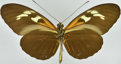

In [4]:
kydoimos['train']['image'][1]

In [5]:
print(kydoimos['train']['image'][0])

<PIL.TiffImagePlugin.TiffImageFile image mode=RGB size=122x64 at 0x29DD80BD8E0>


### Load the upstream dataset into a Pandas dataframe for simpler exploration

In [6]:
kydoimos_df = pd.DataFrame(kydoimos['train'])

# Do this if you would rather not have the actual image data as entries in the dataframe. Since the dataset is small, it's OK.
# kydoimos_df = pd.DataFrame(kydoimos['train'].remove_columns(['image'])) 

In [7]:
kydoimos_df.head(3)

,image,id,NHM specimen number,View,Species,Subspecies,Sex,Type Status
0,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000000,10428329,dorsal,melpomene,thelxiopeia,male,None
1,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000001,10428329,ventral,melpomene,thelxiopeia,male,None
2,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000002,10428331,dorsal,melpomene,thelxiopeia,female,None


In [8]:
kydoimos_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image                110 non-null    object
 1   id                   110 non-null    object
 2   NHM specimen number  110 non-null    int64 
 3   View                 110 non-null    object
 4   Species              110 non-null    object
 5   Subspecies           110 non-null    object
 6   Sex                  110 non-null    object
 7   Type Status          2 non-null      object
dtypes: int64(1), object(7)
memory usage: 7.0+ KB


In [9]:
# kydoimos_df.nunique() # Note that this gives an error due to the 'image' column
kydoimos_df.drop(columns=['image']).nunique()

id                     110
NHM specimen number     38
View                     4
Species                  2
Subspecies               6
Sex                      4
Type Status              1
dtype: int64

## 2. Load Shaggy's dataset

In [10]:
# Load the metadata table into a dataframe
shaggy_dir = '../Shaggy/'
shaggy_df = pd.read_csv(os.path.join(shaggy_dir, 'metadata.csv'), encoding = 'utf-8', low_memory=False)

# Add a column showing how to get to each image from here.
shaggy_df['rel_file_path'] = shaggy_dir + shaggy_df['file_name']

In [11]:
shaggy_df.head(3)

,file_name,Sex,split,rel_file_path
0,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif
1,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif
2,images/melpomene_18.tif,female,train,../Shaggy/images/melpomene_18.tif


In [12]:
shaggy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108 entries, 0 to 107
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   file_name      108 non-null    object
 1   Sex            108 non-null    object
 2   split          108 non-null    object
 3   rel_file_path  108 non-null    object
dtypes: object(4)
memory usage: 3.5+ KB


In [13]:
shaggy_df.nunique()

file_name        108
Sex                4
split              2
rel_file_path    108
dtype: int64

## 3. Run MD5 checksums on all images in Kydoimos and Shaggy's dataset

In [14]:
# MD5 checksum practice ...
hash = hashlib.md5()
hash.update(b'abcdefg')
checksum = hash.hexdigest()
print(f'abcdefg: {checksum}')

hash = hashlib.md5()
hash.update(b'abcdefG')
checksum = hash.hexdigest()
print(f'abcdefG: {checksum}')

# We have further reading available!

abcdefg: 7ac66c0f148de9519b8bd264312c4d64
abcdefG: b75cf09fe732203cf2389bea4c646c27


In [15]:
# Create function for MD5 checksums

# Simple, but could cause OOM error on a massive file
def file_md5_checksum(file_path):
    hash = hashlib.md5()
    with open(file_path, "rb") as f:
        file_bytes = f.read()
        hash.update(file_bytes)
    checksum = hash.hexdigest()
    return checksum

def pil_md5_checksum(image):
    hash = hashlib.md5()
    buffer = BytesIO()
    image.save(buffer, format=image.format)
    hash.update(buffer.getvalue())
    checksum = hash.hexdigest()
    return checksum

In [16]:
# Run MD5 checksum on Shaggy's and Kydoimos datasets
shaggy_df['md5'] = shaggy_df['rel_file_path'].apply(file_md5_checksum)
kydoimos_df['md5'] = kydoimos_df['image'].apply(pil_md5_checksum)
# kydoimos_df['md5'] = [compute_md5(image) for image in kydoimos['train']['image']]

In [17]:
kydoimos_df.head(3)

,image,id,NHM specimen number,View,Species,Subspecies,Sex,Type Status,md5
0,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000000,10428329,dorsal,melpomene,thelxiopeia,male,None,bfe69135302b78cef66df623ddb5befd
1,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000001,10428329,ventral,melpomene,thelxiopeia,male,None,c860654219c233d353277b049610bae4
2,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000002,10428331,dorsal,melpomene,thelxiopeia,female,None,e721585817681ef60e5d0ab81ca00cfd


In [18]:
kydoimos_df.drop(columns=['image']).to_csv('kydoimos.csv', index=False)

In [19]:
shaggy_df.head(3)

,file_name,Sex,split,rel_file_path,md5
0,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif,06dce3c46bdba7ed28cde331a13037bf
1,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif,6b8721ab120e7891ee32bbd5292a81f1
2,images/melpomene_18.tif,female,train,../Shaggy/images/melpomene_18.tif,114f5cd45d57fca44f0474645ef13033


## 4. Merge the datasets on MD5 to link them together

In [20]:
merge_df = pd.merge(shaggy_df, kydoimos_df, on="md5", how="inner")

In [21]:
merge_df.head()

,file_name,Sex_x,split,rel_file_path,md5,image,id,NHM specimen number,View,Species,Subspecies,Sex_y,Type Status


### No matches???
Like, zoinks Scooby. Something is strange here.

There must be something about the image data that has been changed between the Kydoimos dataset and Shaggy's dataset.

Let's list out the things that could affect the MD5 checksum on the binary data for two images:
- Image data content (resizing, cropping, color changes, compression, corruption)
- Image intrinsic metadata

As a shortcut for this class, we'll skip the detective work and get to the solution:

*The intrinsic metadata is changed when the image is loaded as a PIL object, which was done automatically with the Kydoimos dataset by the `datasets` library.*

To address this, we'll load Shaggy's dataset with PIL before taking MD5s again.

In [25]:
# Expect UnidentifiedImageError: cannot identify image file 'C:\\...\\all-hands-2024-data-workshop\\Shaggy\\images\\amalfreda_0.tif'
shaggy_df['image'] = shaggy_df['rel_file_path'].apply(lambda x: Image.open(x)) 

shaggy_df['pil_md5'] = shaggy_df['image'].apply(pil_md5_checksum)

shaggy_df

,file_name,Sex,split,rel_file_path,md5,valid_image,image,pil_md5
0,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif,06dce3c46bdba7ed28cde331a13037bf,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,bc18e0e7467c27c337dcd7ffcc6c4ace
1,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif,6b8721ab120e7891ee32bbd5292a81f1,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,cffe8c60e88431f964e02d42a2faae53
2,images/melpomene_18.tif,female,train,../Shaggy/images/melpomene_18.tif,114f5cd45d57fca44f0474645ef13033,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,259b2e20477d01fad3625a19e1b42e1b
3,images/melpomene_15.tif,male,train,../Shaggy/images/melpomene_15.tif,ff6989dfaf2ee466e44a0e3327630e42,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,1331266d8548a448331d8f737b6abe5f
4,images/melpomene_27.tif,female,train,../Shaggy/images/melpomene_27.tif,5ed6aa878a7ad52b7aa4fd576e95c105,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,deda2e46a5950fb4f36900b7bf913117
...,...,...,...,...,...,...,...,...
103,images/thelxiopeia_15.tif,male,test,../Shaggy/images/thelxiopeia_15.tif,8744aafb012931fd3e6bb31f303c0878,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,c860654219c233d353277b049610bae4
104,images/thelxiopeia_9.tif,male,test,../Shaggy/images/thelxiopeia_9.tif,3aa33ba62b16ca0ee4dc7d18fe8903ca,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,a3087cad4e713f385121af6ca92eb045
105,images/etylus_8.tif,Female,test,../Shaggy/images/etylus_8.tif,0484bcec9638436a1ac64b396f988733,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,4f54ae93cb60136306196c061c0c3982
106,images/thelxiopeia_12.tif,female,test,../Shaggy/images/thelxiopeia_12.tif,e6f96641117fb0c1689d2dd1cce8f275,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,503ef2599a12e0e8389f4cac0c5fef54


In [45]:
shaggy_df

,file_name,Sex,split,rel_file_path,md5,valid_image,image,pil_md5,size
0,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif,06dce3c46bdba7ed28cde331a13037bf,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,bc18e0e7467c27c337dcd7ffcc6c4ace,23.6250
1,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif,6b8721ab120e7891ee32bbd5292a81f1,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,cffe8c60e88431f964e02d42a2faae53,21.3750
2,images/melpomene_18.tif,female,train,../Shaggy/images/melpomene_18.tif,114f5cd45d57fca44f0474645ef13033,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,259b2e20477d01fad3625a19e1b42e1b,21.7500
3,images/melpomene_15.tif,male,train,../Shaggy/images/melpomene_15.tif,ff6989dfaf2ee466e44a0e3327630e42,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,1331266d8548a448331d8f737b6abe5f,22.3125
4,images/melpomene_27.tif,female,train,../Shaggy/images/melpomene_27.tif,5ed6aa878a7ad52b7aa4fd576e95c105,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,deda2e46a5950fb4f36900b7bf913117,21.0000
...,...,...,...,...,...,...,...,...,...
103,images/thelxiopeia_15.tif,male,test,../Shaggy/images/thelxiopeia_15.tif,8744aafb012931fd3e6bb31f303c0878,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,c860654219c233d353277b049610bae4,22.6875
104,images/thelxiopeia_9.tif,male,test,../Shaggy/images/thelxiopeia_9.tif,3aa33ba62b16ca0ee4dc7d18fe8903ca,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,a3087cad4e713f385121af6ca92eb045,22.3125
105,images/etylus_8.tif,Female,test,../Shaggy/images/etylus_8.tif,0484bcec9638436a1ac64b396f988733,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,4f54ae93cb60136306196c061c0c3982,20.8125
106,images/thelxiopeia_12.tif,female,test,../Shaggy/images/thelxiopeia_12.tif,e6f96641117fb0c1689d2dd1cce8f275,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,503ef2599a12e0e8389f4cac0c5fef54,24.0000


In [46]:
img = Image.open('../Shaggy/images/amalfreda_0.tif') # try with amalfreda_1.tif, which will work
img

C:\Users\thompson.4509\AppData\Local\miniconda3\envs\data-workshop-2024\Lib\site-packages\PIL\TiffImagePlugin.py:890: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


UnidentifiedImageError: cannot identify image file 'C:\\Users\\thompson.4509\\projects\\all-hands-2024\\all-hands-2024-data-workshop\\Shaggy\\images\\amalfreda_0.tif'

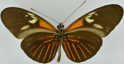

In [47]:
img = Image.open('../Shaggy/images/amalfreda_1.tif') # try with amalfreda_1.tif, which will work
img

In [48]:
# Let's look through the whole set of Shaggy's images and verify the data integrity for each ...

def verify_image(image_path):
    try:
        with Image.open(image_path) as img:
            img.verify()
        return True
    except Exception as e:
        print(f"Corrupted image detected: {image_path}, error: {e}")
        return False

# Apply the function to each image path in the DataFrame
shaggy_df['valid_image'] = shaggy_df['rel_file_path'].apply(verify_image)

# Optionally, you can drop the 'valid_image' column if it's no longer needed
# shaggy_df.drop(columns=['valid_image'], inplace=True)

In [49]:
# Filter the dataframe to remove rows with corrupt images
shaggy_df = shaggy_df[shaggy_df['valid_image']]
# Now go back to apply the `pil_md5_checksum` function

In [50]:
kydoimos_df.info()
# After fix, 110 in kydoimos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110 entries, 0 to 109
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image                110 non-null    object
 1   id                   110 non-null    object
 2   NHM specimen number  110 non-null    int64 
 3   View                 110 non-null    object
 4   Species              110 non-null    object
 5   Subspecies           110 non-null    object
 6   Sex                  110 non-null    object
 7   Type Status          2 non-null      object
 8   md5                  110 non-null    object
dtypes: int64(1), object(8)
memory usage: 7.9+ KB


In [51]:
shaggy_df.info()
# After fix, 107 in shaggy

<class 'pandas.core.frame.DataFrame'>
Index: 106 entries, 0 to 107
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   file_name      106 non-null    object 
 1   Sex            106 non-null    object 
 2   split          106 non-null    object 
 3   rel_file_path  106 non-null    object 
 4   md5            106 non-null    object 
 5   valid_image    106 non-null    bool   
 6   image          106 non-null    object 
 7   pil_md5        106 non-null    object 
 8   size           106 non-null    float64
dtypes: bool(1), float64(1), object(7)
memory usage: 7.6+ KB


In [52]:
merge_df = pd.merge(shaggy_df, kydoimos_df, left_on="pil_md5", right_on="md5", how="inner", suffixes=("_shaggy", "_kydoimos"))
merge_df

,file_name,Sex_shaggy,split,rel_file_path,md5_shaggy,valid_image,image_shaggy,pil_md5,size,image_kydoimos,id,NHM specimen number,View,Species,Subspecies,Sex_kydoimos,Type Status,md5_kydoimos
0,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif,06dce3c46bdba7ed28cde331a13037bf,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,bc18e0e7467c27c337dcd7ffcc6c4ace,23.6250,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000026,10428375,dorsal,melpomene,melpomene,female,None,bc18e0e7467c27c337dcd7ffcc6c4ace
1,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif,06dce3c46bdba7ed28cde331a13037bf,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,bc18e0e7467c27c337dcd7ffcc6c4ace,23.6250,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000102,10428375,dorsal,melpomene,melpomene,female,None,bc18e0e7467c27c337dcd7ffcc6c4ace
2,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif,6b8721ab120e7891ee32bbd5292a81f1,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,cffe8c60e88431f964e02d42a2faae53,21.3750,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000016,10428369,dorsal,melpomene,melpomene,female,None,cffe8c60e88431f964e02d42a2faae53
3,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif,6b8721ab120e7891ee32bbd5292a81f1,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,cffe8c60e88431f964e02d42a2faae53,21.3750,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000092,10428369,dorsal,melpomene,melpomene,female,None,cffe8c60e88431f964e02d42a2faae53
4,images/melpomene_18.tif,female,train,../Shaggy/images/melpomene_18.tif,114f5cd45d57fca44f0474645ef13033,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,259b2e20477d01fad3625a19e1b42e1b,21.7500,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000018,10428370,dorsal,melpomene,melpomene,female,None,259b2e20477d01fad3625a19e1b42e1b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,images/thelxiopeia_9.tif,male,test,../Shaggy/images/thelxiopeia_9.tif,3aa33ba62b16ca0ee4dc7d18fe8903ca,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,a3087cad4e713f385121af6ca92eb045,22.3125,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000085,10428334,ventral,melpomene,thelxiopeia,male,None,a3087cad4e713f385121af6ca92eb045
168,images/etylus_8.tif,Female,test,../Shaggy/images/etylus_8.tif,0484bcec9638436a1ac64b396f988733,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,4f54ae93cb60136306196c061c0c3982,20.8125,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000074,10429061,dorsal,erato,etylus,Female,None,4f54ae93cb60136306196c061c0c3982
169,images/thelxiopeia_12.tif,female,test,../Shaggy/images/thelxiopeia_12.tif,e6f96641117fb0c1689d2dd1cce8f275,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,503ef2599a12e0e8389f4cac0c5fef54,24.0000,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000012,10428336,dorsal,melpomene,thelxiopeia,female,None,503ef2599a12e0e8389f4cac0c5fef54
170,images/thelxiopeia_12.tif,female,test,../Shaggy/images/thelxiopeia_12.tif,e6f96641117fb0c1689d2dd1cce8f275,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,503ef2599a12e0e8389f4cac0c5fef54,24.0000,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000088,10428336,dorsal,melpomene,thelxiopeia,female,None,503ef2599a12e0e8389f4cac0c5fef54


In [53]:
merge_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172 entries, 0 to 171
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   file_name            172 non-null    object 
 1   Sex_shaggy           172 non-null    object 
 2   split                172 non-null    object 
 3   rel_file_path        172 non-null    object 
 4   md5_shaggy           172 non-null    object 
 5   valid_image          172 non-null    bool   
 6   image_shaggy         172 non-null    object 
 7   pil_md5              172 non-null    object 
 8   size                 172 non-null    float64
 9   image_kydoimos       172 non-null    object 
 10  id                   172 non-null    object 
 11  NHM specimen number  172 non-null    int64  
 12  View                 172 non-null    object 
 13  Species              172 non-null    object 
 14  Subspecies           172 non-null    object 
 15  Sex_kydoimos         172 non-null    obj

In [33]:
merge_df['file_name'].nunique() # But Shaggy had 107 images ... where's the extra one hiding? Did something change size?

106

In [36]:
from IPython.display import display
matches = shaggy_df.loc[~shaggy_df['pil_md5'].isin(merge_df['pil_md5']), :]
matches['image'].apply(display)
# shaggy_df.loc[~shaggy_df['pil_md5'].isin(merge_df['pil_md5']), 'image'].apply(display)

Series([], Name: image, dtype: object)

### Looks like some of Shaggy's personal photos found their way into the dataset while he was organizing things ...

In [35]:
shaggy_df = shaggy_df.drop(shaggy_df.loc[~shaggy_df['pil_md5'].isin(merge_df['pil_md5'])].index)


In [37]:
merge_df

,file_name,Sex_shaggy,split,rel_file_path,md5_shaggy,valid_image,image_shaggy,pil_md5,image_kydoimos,id,NHM specimen number,View,Species,Subspecies,Sex_kydoimos,Type Status,md5_kydoimos
0,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif,06dce3c46bdba7ed28cde331a13037bf,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,bc18e0e7467c27c337dcd7ffcc6c4ace,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000026,10428375,dorsal,melpomene,melpomene,female,None,bc18e0e7467c27c337dcd7ffcc6c4ace
1,images/melpomene_26.tif,female,train,../Shaggy/images/melpomene_26.tif,06dce3c46bdba7ed28cde331a13037bf,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,bc18e0e7467c27c337dcd7ffcc6c4ace,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000102,10428375,dorsal,melpomene,melpomene,female,None,bc18e0e7467c27c337dcd7ffcc6c4ace
2,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif,6b8721ab120e7891ee32bbd5292a81f1,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,cffe8c60e88431f964e02d42a2faae53,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000016,10428369,dorsal,melpomene,melpomene,female,None,cffe8c60e88431f964e02d42a2faae53
3,images/melpomene_16.tif,female,train,../Shaggy/images/melpomene_16.tif,6b8721ab120e7891ee32bbd5292a81f1,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,cffe8c60e88431f964e02d42a2faae53,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000092,10428369,dorsal,melpomene,melpomene,female,None,cffe8c60e88431f964e02d42a2faae53
4,images/melpomene_18.tif,female,train,../Shaggy/images/melpomene_18.tif,114f5cd45d57fca44f0474645ef13033,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,259b2e20477d01fad3625a19e1b42e1b,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000018,10428370,dorsal,melpomene,melpomene,female,None,259b2e20477d01fad3625a19e1b42e1b
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,images/thelxiopeia_9.tif,male,test,../Shaggy/images/thelxiopeia_9.tif,3aa33ba62b16ca0ee4dc7d18fe8903ca,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,a3087cad4e713f385121af6ca92eb045,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000085,10428334,ventral,melpomene,thelxiopeia,male,None,a3087cad4e713f385121af6ca92eb045
168,images/etylus_8.tif,Female,test,../Shaggy/images/etylus_8.tif,0484bcec9638436a1ac64b396f988733,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,4f54ae93cb60136306196c061c0c3982,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000074,10429061,dorsal,erato,etylus,Female,None,4f54ae93cb60136306196c061c0c3982
169,images/thelxiopeia_12.tif,female,test,../Shaggy/images/thelxiopeia_12.tif,e6f96641117fb0c1689d2dd1cce8f275,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,503ef2599a12e0e8389f4cac0c5fef54,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000012,10428336,dorsal,melpomene,thelxiopeia,female,None,503ef2599a12e0e8389f4cac0c5fef54
170,images/thelxiopeia_12.tif,female,test,../Shaggy/images/thelxiopeia_12.tif,e6f96641117fb0c1689d2dd1cce8f275,True,<PIL.TiffImagePlugin.TiffImageFile image mode=...,503ef2599a12e0e8389f4cac0c5fef54,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000088,10428336,dorsal,melpomene,thelxiopeia,female,None,503ef2599a12e0e8389f4cac0c5fef54


In [39]:
# We have more images in the merged dataframe compared to either input dataframe. There must be duplicates.
shaggy_dup_mask = shaggy_df.duplicated(subset="pil_md5", keep=False)
shaggy_dups = shaggy_df[shaggy_dup_mask].sort_values(by='pil_md5')
shaggy_dups.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 89 to 11
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   file_name      64 non-null     object 
 1   Sex            64 non-null     object 
 2   split          64 non-null     object 
 3   rel_file_path  64 non-null     object 
 4   md5            64 non-null     object 
 5   valid_image    64 non-null     bool   
 6   image          64 non-null     object 
 7   pil_md5        64 non-null     object 
 8   size           64 non-null     float64
dtypes: bool(1), float64(1), object(7)
memory usage: 4.6+ KB


In [40]:
kydoimos_dup_mask = kydoimos_df.duplicated(subset="md5", keep=False)
kydoimos_dups = kydoimos_df[kydoimos_dup_mask].sort_values(by="md5")
kydoimos_dups.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68 entries, 87 to 78
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   image                68 non-null     object
 1   id                   68 non-null     object
 2   NHM specimen number  68 non-null     int64 
 3   View                 68 non-null     object
 4   Species              68 non-null     object
 5   Subspecies           68 non-null     object
 6   Sex                  68 non-null     object
 7   Type Status          0 non-null      object
 8   md5                  68 non-null     object
dtypes: int64(1), object(8)
memory usage: 5.3+ KB


In [41]:
kydoimos_dups.head(8)

,image,id,NHM specimen number,View,Species,Subspecies,Sex,Type Status,md5
87,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000087,10428335,Ventral,melpomene,thelxiopeia,female,None,071d9b029c6e1c11e746d9068f059bc0
11,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000011,10428335,ventral,melpomene,thelxiopeia,female,None,071d9b029c6e1c11e746d9068f059bc0
28,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000028,10428636,dorsal,erato,amalfreda,male,None,0c9c7e358752c5ca0cee78a1f004dad3
104,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000104,10428636,dorsal,erato,amalfreda,male,None,0c9c7e358752c5ca0cee78a1f004dad3
90,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000090,10428367,dorsal,melpomene,melpomene,male,None,0ddc9f7f438072615a3e8c392a05930a
14,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000014,10428367,dorsal,melpomene,melpomene,male,None,0ddc9f7f438072615a3e8c392a05930a
30,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000030,10428637,dorsal,erato,amalfreda,male,None,0f11ac8ad6633547904314acbefa2115
106,<PIL.TiffImagePlugin.TiffImageFile image mode=...,KDS000106,10428637,dorsal,erato,amalfreda,male,None,0f11ac8ad6633547904314acbefa2115


Quite a few duplicates come from the upstream dataset
It looks like these are coming from unique "id" but identical "NHM specimen number" entries. 

Now that we know duplicates are an issue, we should check if we have duplicates between our test and train splits.

In [43]:
# shaggy_dups
grouped = shaggy_dups.groupby('pil_md5')['split'].unique()

# Filter groups where both 'test' and 'train' are present
both_splits = grouped[grouped.apply(lambda x: 'test' in x and 'train' in x)]

# Count the number of 'pil_md5' values present in both 'test' and 'train'
print(both_splits.size)

15


That's the final nail in the coffin for Shaggy's dataset. We are going to need to start over!